# Analysis of Letter Recognition dataset
## -Ravi Teja

Analysis of unsupervised learning methods such as K-Means and EM, dimensionality reduction methods such as PCA,ICA and Random Projections, and their effect on Neural Network classification accuracy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FastICA
from sklearn import metrics,random_projection,mixture
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import time
%matplotlib inline

In [62]:
train = pd.read_csv("data/letter.csv")

In [63]:
#Remove the label data from training data
labels = train['Output']
train = train.drop("Output",axis=1)

In [64]:
#View train data
train.head()

,X-box,Y-box,Width,High,Onpix,X-bar,Y-bar,X2bar,Y2bar,Xybar,X2ybr,Xy2br,X-ege,Xegvy,Y-ege,Yegvx
0,2,4,4,3,2,7,8,2,9,11,7,7,1,8,5,6
1,4,7,5,5,5,5,9,6,4,8,7,9,2,9,7,10
2,7,10,8,7,4,8,8,5,10,11,2,8,2,5,5,10
3,4,9,5,7,4,7,7,13,1,7,6,8,3,8,0,8
4,6,7,8,5,4,7,6,3,7,10,7,9,3,8,3,7


In [65]:
#Center the data and scale to unit variance
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(train)  #X/X.std(axis=0)

In [6]:
#Assign labels to clusters based on most common label - helps in some analysis later
def asgn_labels(kmeans,labels):
    infer = {}
    for cluster in range(len(kmeans.cluster_centers_)):
        l = [labels[i] for i in range(len(kmeans.labels_)) if kmeans.labels_[i]==cluster]
        infer[cluster] = max(set(l), key=l.count)
    return infer

# K Means

Two metrics are used throughout this analysis for evaluation:
a) Silhouette Coefficient: It is a measure of the mean intra-cluster and mean nearest-cluster distance. The range is [-1,1]. The better the clusters are formed, the higher is the score. This does not use the ground truth label information that we have.
b) Adjusted Mutual Information Score : This measures the mutual information between the formed clusters and the ground truth labels. The mutual information is then adjusted to account for chance. The range is [0,1].

In [7]:
# Apply Kmeans without dimensionality reduction
kmeans = KMeans(n_clusters=26).fit(X_std)
print metrics.silhouette_score(X_std,kmeans.labels_),metrics.adjusted_mutual_info_score(labels,kmeans.labels_)

0.145991424208 0.376059365358


In [8]:
#Visualize a few cluster centroids, along with most common label occuring in the cluster
for c in range(6):
    #print kmeans.cluster_centers_[c]
    l = [labels[i] for i in range(len(kmeans.labels_)) if kmeans.labels_[i]==c]
    t = max(set(l), key=l.count)
    print "Cluster label:",t," Size:",len(l)," Correct%:",float(len([i for i in l if i==t]))/len(l)

Cluster label: Z  Size: 736  Correct%: 0.463315217391
Cluster label: P  Size: 953  Correct%: 0.205666316894
Cluster label: U  Size: 666  Correct%: 0.268768768769
Cluster label: Y  Size: 925  Correct%: 0.0983783783784
Cluster label: O  Size: 1331  Correct%: 0.223140495868
Cluster label: T  Size: 724  Correct%: 0.343922651934


The correct percentages do not look great above. But its much better than random assignments whose correct percentage would be around 1/26 = 0.038. 


Let us change number of clusters. Ideal expectation is 26 as the alphabet size is 26. So a range around 26 is chosen.

In [32]:
#Let us vary number of clusters
def kmeans(data):
    clusters=[] #number of clusters in each iteration
    kmeans_S=[] #the Silhouette coeffs
    kmeans_MI=[]  #the Adjusted MI scores
    times=[] #time for each iteration
    for n in range(5,41,5):
        start=time.time()
        kmeans = KMeans(n_clusters=n,n_init=5).fit(X_std)
        end=time.time()
        clusters.append(n)
        kmeans_S.append(metrics.silhouette_score(data, kmeans.labels_, metric='euclidean'))
        kmeans_MI.append(metrics.adjusted_mutual_info_score(labels,kmeans.labels_))
        times.append(end-start)
    return clusters,kmeans_S,kmeans_MI,times

We will run the above function after defining EM below, so that a comparison can be made.

# EM algorithm

In [10]:
# Vary num clusters of Gaussian Mixture Model (with Full Covariance) and do prediction
def em(data):
    clusters=[]  #store number of clusters
    EM_S=[]
    EM_MI=[]
    times=[]    #Time taken for each iteration
    for n in range(5,41,5):
        start = time.time()
        clf = GaussianMixture(n_components=n, covariance_type='spherical')
        clf.fit(data)
        end=time.time()
        pred=clf.predict(data)
        clusters.append(n)
        EM_S.append(metrics.silhouette_score(X_std, pred, metric='euclidean'))
        EM_MI.append(metrics.adjusted_mutual_info_score(labels,pred))
        times.append(end-start)
    return clusters,EM_S,EM_MI,times

In [11]:
clusters,EM_S,EM_MI,EM_times = em(X_std)

In [12]:
clusters,kmeans_S,kmeans_MI,kmeans_times = kmeans(X_std)

We will now compare the error metrics and the time taken against the number of clusters. The comparison is between KMeans and EM.

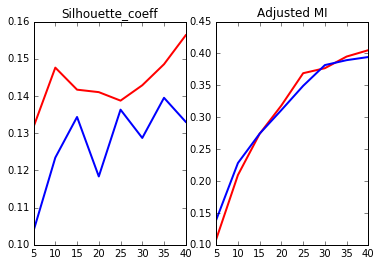

In [13]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,kmeans_S,'r',clusters,EM_S,'b',linewidth=2.0) #Red represents K Means, Blue represents EM
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,kmeans_MI,'r',clusters,EM_MI,'b',linewidth=2.0)
plt.title("Adjusted MI")
plt.show()

Silhouette coeff increases slowly, but Adjusted Mi improves significantly with increasing clusters.
In both cases, EM is almost equal or slightly better than K Means. 

# 1) Apply PCA

In [68]:
# 1) Apply PCA 
pca =PCA(n_components=11)
pca.fit(X_std)
print pca.explained_variance_ratio_.cumsum()[10]
X_pca = pca.transform(X_std)

0.941962649145


With number of components as 11, the amount of variance retained is 94%. Its not bad, and we will proceed with these 11 components.

In [15]:
# Apply K-Means with varying k
clusters,KM_pca_S,KM_pca_MI,KM_pca_times = kmeans(X_pca)

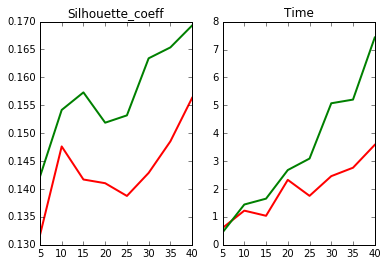

In [16]:
#Comparison of Kmeans with and without PCA
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,kmeans_S,'r',clusters,KM_pca_S,'g',linewidth=2.0) #Red represents without and Green represents with PCA
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,kmeans_times,'r',clusters,KM_pca_times,'g',linewidth=2.0) 
plt.title("Time")
plt.show()

The clusters are better formed when PCA is applied as explained by the first graph. The time taken is almost same until 35 clusters, after which the reduced data seems to be increasingly performing better compared to the other

In [17]:
# Perform EM with varying number of clusters
clusters,EM_pca_S,EM_pca_MI,EM_pca_times = em(X_pca)

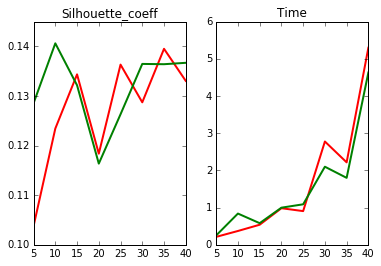

In [18]:
#Comparison of EM with and without PCA
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,EM_S,'r',clusters,EM_pca_S,'g',linewidth=2.0) #Red represents without and Green represents with PCA
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,EM_times,'r',clusters,EM_pca_times,'g',linewidth=2.0) 
plt.title("Time")
plt.show()

Both the graphs are very similar in performance. The only interesting observation is that when number of clusters is pretty low(=5), it can still form good clusters for data with reduced dimensions. Let us for once also check if EM with the PCA reduced data matches well even with the ground truth labels.

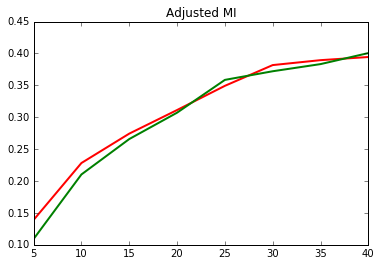

In [19]:
plt.plot(clusters,EM_MI,'r',clusters,EM_pca_MI,'g',linewidth=2.0)
plt.title("Adjusted MI")
plt.show()

In both cases, increasing number of clusters increases mutual info with the original labels.

# 2)Apply ICA

In [74]:
ica = FastICA(n_components=11)
S_ = ica.fit_transform(X_std)
A_ = ica.mixing_

In [21]:
#Vary num clusters for fixed ICA
clusters,KM_ica_S,KM_ica_MI,KM_ica_times = kmeans(S_)

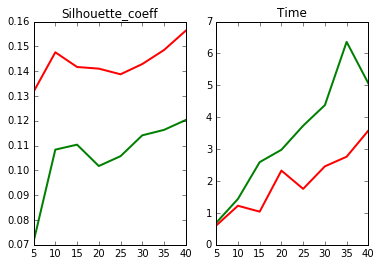

In [22]:
#Comparison of Kmeans with and without ICA
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,kmeans_S,'r',clusters,KM_ica_S,'g',linewidth=2.0) #Red represents without and Green represents with ICA
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,kmeans_times,'r',clusters,KM_ica_times,'g',linewidth=2.0) 
plt.title("Time")
plt.show()

/Users/raviteja/Development/anaconda/envs/gl-env/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


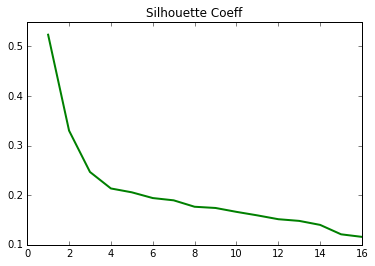

In [23]:
#Let us fix clusters at 26, but Vary ICA parameter and measure silhouette_score
scores=[]
for n_components in range(1,17):
    ica = FastICA(n_components=n_components)
    S_ = ica.fit_transform(X_std)
    kmeans = KMeans(n_clusters=26,n_init=5).fit(S_)
    scores.append((metrics.silhouette_score(S_, kmeans.labels_, metric='euclidean')))
plt.plot(range(1,17),scores,'g',linewidth=2.0)
plt.title("Silhouette Coeff")
plt.show()    

As the number of dimensions increase, it becomes more difficult to form well defined clusters, and hence silhouette_score decreases. We could as well choose a low parameter for K (around 2 for Letters and 20 for MNIST). But we may lose components that contain information related to the actual ground truth labels. So let us perform the above experiment with Adjusted MI to see how well they match with the ground truth.

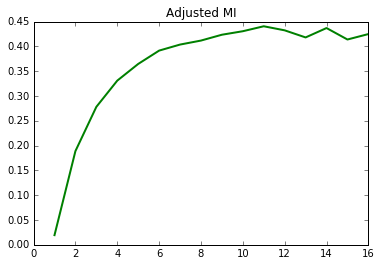

In [24]:
#Let us repeat above experiment this time measuring Adjusted MI
scores=[]
for n_components in range(1,17):
    ica = FastICA(n_components=n_components)
    S_ = ica.fit_transform(X_std)
    kmeans = KMeans(n_clusters=26,n_init=5).fit(S_)
    scores.append(metrics.adjusted_mutual_info_score(labels,kmeans.labels_))
plt.plot(range(1,17),scores,'g',linewidth=2.0)
plt.title("Adjusted MI")
plt.show()

Although it becomes difficult to form well defined clusters, more information from the original data is captured by increasing the number components returned by ICA. Thus, the accuracy increases with number of components.
 Another observation is that it plateaus after 10 components and in many of the runs, it slightly decreases afterwards. Its probably because there are not more than 10 independent components in the original data.

In [77]:
#Let's calculate average kurtosis of original data
from scipy.stats import kurtosis
total = 0
for i in range(16):
    total += kurtosis(X_std[:,i])
print total/16

0.697263493264


In [75]:
#Average kurtosis of transformed data
total = 0
for i in range(16):
    total += kurtosis(S_[:,i])
print total/16

4.00947929875


Clearly the increase in value shows the distribution was previously more similar to Gaussian, and less similar after tranformation

Perfectly Normal distribution has Kurtotis = 0

In [27]:
# Perform EM with varying number of clusters - Used for analysis later
clusters,EM_ica_S,EM_ica_MI,EM_ica_times = em(S_)

# 3) Random Projection

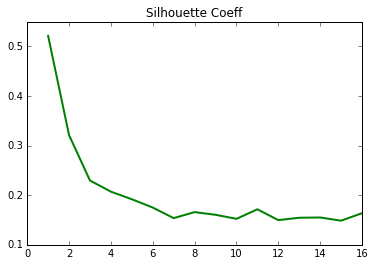

In [28]:
#Let us fix K Means clusters at 26, but vary number of RP components and measure silhouette_score
scores_A=[]
for n_components in range(1,17):
    rand = random_projection.GaussianRandomProjection(n_components=n_components)
    X_rand = rand.fit_transform(X_std)
    kmeans = KMeans(n_clusters=26,n_init=5).fit(X_rand)
    scores_A.append((metrics.silhouette_score(X_rand, kmeans.labels_, metric='euclidean')))
plt.plot(range(1,17),scores_A,'g',linewidth=2.0)
plt.title("Silhouette Coeff")
plt.show()  

In [29]:
#Let us fix all parameters constant, but perform repeated runs to see the variation due to randomness of RP
scoresB=[]
for n_components in range(1,17):
    rand = random_projection.GaussianRandomProjection(n_components=11)
    X_rand = rand.fit_transform(X_std)
    kmeans = KMeans(n_clusters=26,n_init=5).fit(X_rand)
    scoresB.append((metrics.silhouette_score(X_rand, kmeans.labels_, metric='euclidean')))

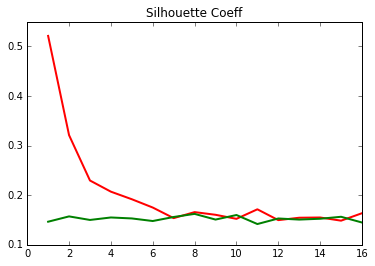

In [30]:
plt.plot(range(1,17),scores_A,'r',range(1,17),scoresB,'g',linewidth=2.0)
plt.title("Silhouette Coeff")
plt.show()

The red line above represents variation with respect to RP components. The green line represents repeated runs without changing any of the parameters. The accuracy of RP can change without varying parameters as we choose the components randomly. The purpose of this graph is to compare the variation of RP without parameter change compared to variation of RP with parameter change. Clearly, the variation of green line is reasonably consistent. 

In [33]:
#Perform K-Means with varying num clusters
rand = random_projection.GaussianRandomProjection(n_components=11)
X_rand = rand.fit_transform(X_std)
clusters,KM_rand_S,KM_rand_MI,KM_rand_times = kmeans(X_rand)

In [34]:
# Perform EM with varying number of clusters
clusters,EM_rand_S,EM_rand_MI,EM_rand_times = em(X_rand)

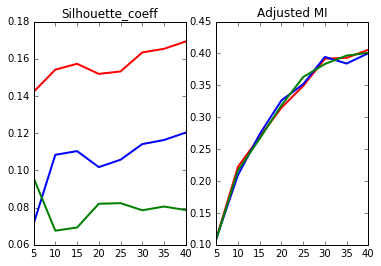

In [35]:
#Plotting the accuracy of all the 3 methods for KMeans - PCA,ICA,RP
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,KM_pca_S,'r',clusters,KM_ica_S,'b',clusters,KM_rand_S,'g',linewidth=2.0) 
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,KM_pca_MI,'r',clusters,KM_ica_MI,'b',clusters,KM_rand_MI,'g',linewidth=2.0) 
plt.title("Adjusted MI")
plt.show()

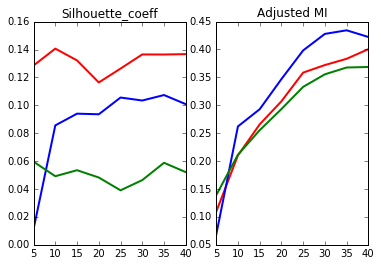

In [36]:
#Plotting the accuracy of all the 3 methods for EM - PCA,ICA,RP
plt.figure()
plt.subplot(1,2,1)
plt.plot(clusters,EM_pca_S,'r',clusters,EM_ica_S,'b',clusters,EM_rand_S,'g',linewidth=2.0) 
plt.title("Silhouette_coeff")
plt.subplot(1,2,2)
plt.plot(clusters,EM_pca_MI,'r',clusters,EM_ica_MI,'b',clusters,EM_rand_MI,'g',linewidth=2.0) 
plt.title("Adjusted MI")
plt.show()

In both datasets, RP is able to do as well as others in ground truth classification even though its random.

# Reconstruction Error

Let us reconstruct the original data, and see how much information is preserved for each of the dimension reduction algorithms. The metric to evaluate is the mean distance between the original and the new data points.

In [51]:
#Loss function
loss = lambda X,proj: np.sqrt(((X - proj) ** 2).sum(axis=1)).mean()

In [71]:
proj = pca.inverse_transform(X_pca)
print loss(X_std,proj)
proj = ica.inverse_transform(S_)
print loss(X_std,proj)
#Scikit doesn't seem to have inverse_transform for Random Projection. Let's calculate it
from numpy.linalg import inv
proj = np.dot(rand.components_.T,X_rand.T).T
print loss(X_std,proj)

0.875734946497
1.06439701055
4.62481535427


Random projections has significantly higher reconstruction error.

# Neural Network performance after dimension reduction

In previous assignment, using WEKA, a neural network with 1 hidden layer (with 21 nodes) was trained for the original letters dataset. We train a neural network again with original and PCA reduced data to compare performances.

In [127]:
#Run with original data
X_train, X_test, y_train, y_test = train_test_split(X_std, labels, test_size=0.33, random_state=42)
clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(21),alpha=0,learning_rate_init=0.3,momentum=0.9)
clf.fit(X_train,y_train)
print float(sum(clf.predict(X_test) == y_test))/len(y_test)

0.859393939394


In [358]:
#Run after PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.33, random_state=42)
clf.fit(X_train,y_train)
print float(sum(clf.predict(X_test) == y_test))/len(y_test)

0.805909090909


It is slightly less than original accuracy. The accuracy percentage decrease in slightly more than the variance percentage decrease after performing PCA. It is possible that the low variance components that we ignored had slightly more information than expected.

In [125]:
#Let us change the number of hidden nodes in the single hidden layer and plot the performances
orig_result=[]
pca_result=[]
x_axis=[]
for nodes in range(50,1500,100):
    clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(nodes),alpha=0,learning_rate_init=0.3,momentum=0.9)
    #Original
    X_train, X_test, y_train, y_test = train_test_split(X_std, labels, test_size=0.33, random_state=42)
    clf.fit(X_train,y_train)
    orig_result.append(float(sum(clf.predict(X_test) == y_test))/len(y_test))
    #PCA
    X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.33, random_state=42)
    clf.fit(X_train,y_train)
    pca_result.append(float(sum(clf.predict(X_test) == y_test))/len(y_test))
    x_axis.append(nodes)

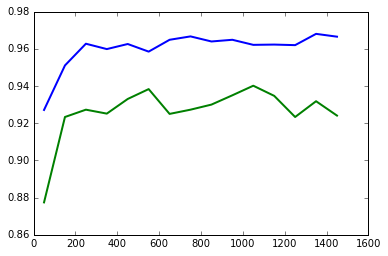

In [126]:
plt.plot(x_axis, orig_result,x_axis,pca_result,linewidth=2.0)
plt.show()

The accuracy saturates at around 96% for original and 93% for PCA applied data. Clearly, there is lost information.

In [75]:
#Let us check for ICA
for n in range(9,17):
    ica = FastICA(n_components=n)
    S_ = ica.fit_transform(X_std)
    start = time.time()
    clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(21),alpha=0,learning_rate_init=0.3,momentum=0.9)
    clf.fit(S_,labels)
    end = time.time()
    print n,"  ",float(sum(clf.predict(S_) == labels))/len(labels)

9    0.123
10    0.16185
11    0.04315
12    0.06815
13    0.03875
14    0.24545
15    0.03915
16    0.23575


# K Means/EM output as a feature for Neural Network

Let us check the neural network performance as above, but with an additional feature which is the clustering output of K Means

In [342]:
kmeans = KMeans(n_clusters=21,n_init=10).fit(X_std)
X = np.concatenate((X_std,kmeans.labels_.T[:,None]),axis=1)
X = StandardScaler().fit_transform(X)
print X.shape

(20000, 17)


In [341]:
# Repeat the Neural Network experiment
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)
clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(21),alpha=0,learning_rate_init=0.3,momentum=0.9)
clf.fit(X_train,y_train)
print float(sum(clf.predict(X_test) == y_test))/len(y_test)

0.857121212121


On an average, the percentage of correct classification remains almost the same and there is not much of an increase(even without this new feature, the accuracy averaged around 85%). It is probably due to clustering feature not providing much extra information than what the NN knows already. Let us check if it the same case after applying PCA.

In [359]:
# Repeat the above experiment after applying PCA
kmeans = KMeans(n_clusters=21,n_init=10).fit(X_pca)
X = np.concatenate((X_pca,kmeans.labels_[:,None]),axis=1)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)
clf = MLPClassifier(solver='sgd',hidden_layer_sizes=(21),alpha=0,learning_rate_init=0.3,momentum=0.9)
clf.fit(X_train,y_train)
print float(sum(clf.predict(X_test) == y_test))/len(y_test)

0.799848484848


Even in this case, the percentage remains almost the same